<a href="https://colab.research.google.com/github/parmarsuraj99/keras-transformer-flex/blob/master/DETR/DETR_Exp_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from attn_augconv import *
import tensorflow.keras.layers as L
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model

from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img

In [0]:
def scaled_dot_product_attention(query, key, value, mask):
  """Calculate the attention weights. """
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # scale matmul_qk
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # add the mask to zero out padding tokens
  if mask is not None:
    logits += (mask * -1e9)

  # softmax is normalized on the last axis (seq_len_k)
  attention_weights = tf.nn.softmax(logits, axis=-1)

  output = tf.matmul(attention_weights, value)

  return output

In [0]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, query, key, value, mask):
    batch_size = tf.shape(query)[0]

    # linear layers
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # split heads
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # scaled dot-product attention
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # concatenation of heads
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # final linear layer
    outputs = self.dense(concat_attention)

    return outputs

In [447]:
temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
y = tf.random.uniform((20, 30, 512))  # (batch_size, encoder_sequence, d_model)
out = temp_mha(y, y, y, mask=None)
out.shape

TensorShape([20, 30, 512])

In [0]:
def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])


In [0]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.self_attn = MultiHeadAttention(d_model, num_heads)
    self.ffn1 = tf.keras.layers.Dense(dff, activation='relu')
    self.dropout = tf.keras.layers.Dropout(rate)
    self.ffn2 = tf.keras.layers.Dense(d_model)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    
  def call(self, x, training, mask=None):
    
    src2 = self.self_attn(x, x, x, mask)
    x = x + self.dropout1(src2, training)
    x = self.layernorm1(x)
    #print(x.shape)
    src2 = self.ffn2(self.dropout(self.ffn1(x), training))
    #print(src2.shape)
    x = x + self.dropout2(src2, training)
    x = self.layernorm2(x)

    return x

In [457]:
sample_encoder_layer = EncoderLayer(512, 8, 2048)

sample_encoder_layer_output = sample_encoder_layer(
    tf.random.uniform((64, 50, 512)), False, None)

sample_encoder_layer_output.shape  # (batch_size, input_seq_len, d_model)


TensorShape([64, 50, 512])

In [0]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(DecoderLayer, self).__init__()

    self.self_attn = MultiHeadAttention(d_model, num_heads)
    self.mha = MultiHeadAttention(d_model, num_heads)

    self.ffn1 = tf.keras.layers.Dense(dff, activation='relu')
    self.dropout = tf.keras.layers.Dropout(rate)
    self.ffn2 = tf.keras.layers.Dense(d_model)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)
    
    
  def call(self, tgt, enc_output, training, 
           look_ahead_mask=None, padding_mask=None):
    # enc_output.shape == (batch_size, input_seq_len, d_model)
    #print(tgt.shape)
    tgt2 = self.self_attn(tgt, tgt, tgt, mask=look_ahead_mask)
    #print(tgt2.shape)
    tgt = tgt + self.dropout1(tgt2)
    tgt = self.layernorm1(tgt)
    #print(enc_output.shape)
    tgt2 = self.mha(tgt, enc_output, enc_output, mask=look_ahead_mask)

    tgt = tgt + self.dropout2(tgt2)
    tgt = self.layernorm2(tgt)
    tgt2 = self.ffn2(self.dropout(self.ffn1(tgt),training))
    tgt = tgt + self.dropout3(tgt2)
    tgt = self.layernorm3(tgt)

    return tgt

In [458]:
sample_decoder_layer = DecoderLayer(512, 8, 2048)

sample_decoder_layer_output= sample_decoder_layer(
    tf.random.uniform((64, 20, 512)), sample_encoder_layer_output, 
    False, None, None)

sample_decoder_layer_output.shape  # (batch_size, target_seq_len, d_model)


TensorShape([64, 20, 512])

In [0]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, rate=0.1):
    super(Encoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    
    self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]

    
    self.dropout = tf.keras.layers.Dropout(rate)
        
  def call(self, x, training, mask):

    x = self.dropout(x, training=training)
    
    for i in range(self.num_layers):
      x = self.enc_layers[i](x, training, mask)
    
    return x  # (batch_size, input_seq_len, d_model)


In [460]:
sample_encoder = Encoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048)
temp_input = tf.random.uniform((62, 64, 512), dtype=tf.float32, minval=0, maxval=200)

sample_encoder_output = sample_encoder(temp_input, training=False, mask=None)

print(sample_encoder_output.shape)  # (batch_size, input_seq_len, d_model)


(62, 64, 512)


In [0]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate)
    
  def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):

    attention_weights = {}

    for i in range(self.num_layers):
      x = self.dec_layers[i](x, enc_output, training,
                                             look_ahead_mask, padding_mask)
    
    # x.shape == (batch_size, target_seq_len, d_model)
    return x


In [464]:
sample_decoder = Decoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048)
temp_input = tf.random.uniform((62, 64, 512), dtype=tf.float32, minval=0, maxval=200)

output = sample_decoder(temp_input, 
                              enc_output=sample_encoder_output, 
                              training=False,
                              look_ahead_mask=None, 
                              padding_mask=None)

output.shape


TensorShape([62, 64, 512])

In [0]:
class Transformer(tf.keras.Model):
  def __init__(self, num_encoding_layers=6, num_decoding_layers=6, d_model=512, num_heads=8, dff=2048, rate=0.1):
    super(Transformer, self).__init__()

    self.encoder = Encoder(num_encoding_layers, d_model, num_heads, dff, rate)

    self.decoder = Decoder(num_decoding_layers, d_model, num_heads, dff, rate)
    
  def call(self, inp, tar, training, enc_padding_mask=None, 
           look_ahead_mask=None, dec_padding_mask=None):

    enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)
    
    # dec_output.shape == (batch_size, tar_seq_len, d_model)
    dec_output = self.decoder(
        tar, enc_output, training, look_ahead_mask, dec_padding_mask)
    
    return dec_output

In [0]:
model = Transformer()

In [0]:
src = tf.random.uniform([10, 32, 512])
tgt = tf.random.uniform([20, 32, 512])

In [0]:
ps = model(src, tgt, training=False)

In [472]:
ps.shape

TensorShape([20, 32, 512])

In [0]:
tf.keras.backend.set_image_data_format('channels_first')

In [0]:
from tensorflow.keras import layers

class DETR(layers.Layer):

  def __init__(self, num_classes, hidden_dim, nheads,
               num_encoder_layers, num_decoder_layers):
    super(DETR, self).__init__()
    self.backbone = tf.keras.applications.ResNet50(
            input_shape=(3, None, None),
            include_top=False,
            weights="imagenet",
            )
    self.conv = L.Conv2D(hidden_dim, 1)
    self.transformer = Transformer(d_model = hidden_dim, num_heads=nheads,
                                   num_encoding_layers=num_encoder_layers,
                                   num_decoding_layers=num_decoder_layers)
    self.linear_class = L.Dense(num_classes+1)
    self.linear_bbox = L.Dense(4, activation="sigmoid")
    self.query_pos = tf.Variable(tf.random.uniform([100, hidden_dim]))
    self.row_embed = tf.Variable(tf.random.uniform([50, hidden_dim//2]))
    self.col_embed = tf.Variable(tf.random.uniform([50, hidden_dim//2]))


  def call(self, inputs):
      x = self.backbone(inputs)
      h = self.conv(x)
      print(h.shape)
      H, W  = h.shape[-2:]
      print(H, W)
      print(self.query_pos.shape)
      cated = tf.concat([tf.tile(tf.expand_dims(self.col_embed[:W], 0), [H, 1, 1]),
                         tf.tile(tf.expand_dims(self.row_embed[:H], 1), [1, W, 1])
                         ], axis = -1)
      cated = tf.expand_dims(tf.reshape(cated, [H*W, -1]), 0)

      print(cated.shape)
      h = self.transformer(cated + tf.reshape(h, [1, H*W, -1]),
                           tf.expand_dims(self.query_pos, 0))
      print(h.shape)
      #h = tf.transpose(h, [1, 0, 2])

      scores_c = self.linear_class(h)
      scores_box = self.linear_bbox(h)

      return scores_c, scores_box
    


In [510]:
gc.collect()
detr = DETR(num_classes=91, hidden_dim=256, 
            nheads=8, num_encoder_layers=6,
            num_decoder_layers=6)

x = tf.random.normal(shape=[1, 3, 800, 1300])
c, b = detr(x)

(1, 256, 25, 41)
25 41
(100, 256)
(1, 1025, 256)
(1, 100, 256)


In [505]:
c.shape, b.shape

(TensorShape([1, 100, 92]), TensorShape([1, 100, 4]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


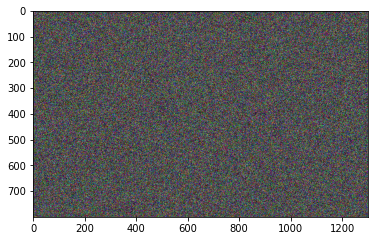

In [495]:
plt.imshow(x.numpy().reshape(800, 1300, 3))